In [44]:
import pandas as pd
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score, precision_score, recall_score, \
    precision_recall_curve

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import clone
from tqdm import tqdm

import os
from gensim.models import KeyedVectors
from gensim.downloader import base_dir

import random

In [503]:
#Dataframe  generated in analye-data.ipynb
df = pd.read_json("./Trec_data/Features_Labeled.json", orient='records',lines=True)
df

,eventID,eventType,postID,postCategories,postPriority,text,entities,extended_entities,favorite_count,hashtagEntities,...,bool_EmergingThreats,bool_Weather,bool_Volunteer,bool_Hashtags,bool_OriginalEvent,bool_ContextualInformation,bool_InformationWanted,bool_GoodsServices,bool_SearchAndRescue,bool_Location
0,fireColorado2012,wildfire,212311994286620672,[MultimediaShare],Unknown,RT @CBSDenver: The copter is on the way to the...,"{'symbols': [], 'urls': [], 'hashtags': [{'tex...",None,0.0,None,...,False,False,False,False,False,False,False,False,False,False
1,fireColorado2012,wildfire,217746356842926080,[MultimediaShare],Medium,RT @ColoradoRapids: Photo of #FlagStaffFire in...,"{'symbols': [], 'urls': [], 'hashtags': [{'tex...",None,0.0,None,...,False,False,False,False,False,False,False,False,False,False
2,fireColorado2012,wildfire,217732012314861568,[FirstPartyObservation],Medium,2 wildfires in Boulder County. We can see smok...,"{'symbols': [], 'urls': [], 'hashtags': [], 'u...",None,0.0,None,...,False,False,False,False,False,False,False,False,False,False
3,fireColorado2012,wildfire,216961334129078272,[Discussion],Low,RT @Jon_G3: Seeing 1/3 of Colorado on fire mak...,"{'symbols': [], 'urls': [], 'hashtags': [{'tex...",None,0.0,None,...,False,False,False,False,False,False,False,False,False,False
4,fireColorado2012,wildfire,212552860590813184,[MultimediaShare],Medium,RT @dhorning11: RT @LarimerCounty: #HighParkFi...,"{'symbols': [], 'urls': [{'expanded_url': 'htt...",None,0.0,None,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38071,tennesseeTornadoOutbreak2020,tornado,1235236359310368768,"[ThirdPartyObservation, Weather, Location, Mul...",Low,Hottest Google Search in 31.2 hrs. Nashville t...,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",None,0.0,None,...,False,True,False,False,False,True,False,False,False,True
38072,tennesseeTornadoOutbreak2020,tornado,1235337290144239616,"[ThirdPartyObservation, Location, MultimediaSh...",Low,A live report is next on the Nashville tornado...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",None,0.0,None,...,False,False,False,False,False,False,False,False,False,True
38073,tennesseeTornadoOutbreak2020,tornado,1235258820139638784,"[ThirdPartyObservation, Weather, Location, Mul...",Low,Officials are still cleaning up after tornadoe...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",None,0.0,None,...,False,True,False,False,False,False,False,False,False,True
38074,tennesseeTornadoOutbreak2020,tornado,1235253249957126144,"[ThirdPartyObservation, Weather, Location, Mul...",Low,Putnam County: Cookeville area tornado victims...,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",None,0.0,None,...,False,True,False,False,False,False,False,False,False,True


# **`Generate Heldout Events`**

In [538]:
fullEventTypes = df['eventType'].unique()
eventTypes = []
for event in fullEventTypes:
    events = df.loc[df['eventType'] == event]['eventID'].unique()
    if events.size > 1:
        eventTypes.append(event)
print(eventTypes)

['wildfire', 'earthquake', 'flood', 'typhoon', 'shooting', 'bombing', 'storm']


In [142]:
heldout_events = {}

#Choose heldout event and saves in the heldout_events dataframe
for event in eventTypes:
    crises = df.loc[df['eventType']==event]['eventID'].unique()
    heldout_events[event]=[crises[random.choice(np.arange(crises.size))]]

heldout_events = pd.DataFrame.from_dict(heldout_events)
heldout_events.to_json('./Trec_data/heldout_events.json')

(5,)
(11,)
(11,)
(9,)
(10,)
(3,)
(2,)


In [593]:
#Simple read to keep the index by events
heldout_events = pd.read_json('./Trec_data/heldout_events.json')
heldout_events

,wildfire,earthquake,flood,typhoon,shooting,bombing,storm
0,siberianWildfires2020,nepalEarthquake2015,southAfricaFloods2019,typhoonLekima2020,elPasoWalmartShooting2020,parisAttacks2015,tennesseeDerecho2020


# **`Model Related Methods`**

In [87]:
def train_data(data, column, heldout_ids):
    training = data.loc[~data[column].isin(heldout_ids)]
    
    return training

def test_data(data, column, heldout_ids):
    test = data.loc[data[column].isin(heldout_ids)]
    
    return test

In [88]:
def generate_model(data, features, target, modelType):
    
    model = clone(modelType)
    model.fit(data[features], data[target])
    
    return model

In [89]:
def generate_model_by_events(data, features, target, modelType):
    modelList = {}
    for event in tqdm(eventTypes):
        #Create training and test dataframe
        eventDF = df.loc[df['eventType']==event]
        
        training = train_data(eventDF, 'eventID', heldout_events[event])
        
        #generate event specific model
        model = generate_model(training, features, target, modelType)
        
        #Add model to list
        modelList[event] = model
        
        #print('')
    return modelList

# **`Generate Generic Variables`**

In [124]:
features = ["num_chars", "num_chars_total", 
            "num_terms", "num_words", "num_unique_words", "vader neg", "vader pos",
            "vader neu", "vader compound", 
            "num_hashtags", "num_mentions", 
            "num_urls", 
            "is_retweet", "num_media",
            "is_verified", 
            "caps_ratio"]

#I think you need to make a list of lists

rf_params = {
    'random_state': 1337,
    'class_weight': 'balanced',
    'n_estimators': 128, 
    'n_jobs': -1,
    'max_depth': 50,
    'max_features': 14,
    'min_samples_leaf': 33,
    'min_samples_split': 96,
    'verbose': 1
}

heldout_event_ids = []

for item in heldout_events.loc[0]:
    heldout_event_ids.append(item)
    
heldout_event_ids

#Training data withholding all heldout events for general models
generalTraining = train_data(df, 'eventID', heldout_event_ids) #Check this
print(generalTraining.shape)

(33438, 70)


# **`Generate postPriority Models`**

In [92]:
prioLabel = 'postPriority'
prioModel = RandomForestClassifier(**rf_params) #(**modelParameters)

#generate general model
genPrioModel = generate_model(generalTraining, features, prioLabel, prioModel)

#generate event specific models
specPrioModels = generate_model_by_events(df, features, prioLabel, prioModel)

100%|██████████| 7/7 [00:10<00:00,  1.48s/it]


# **`Generate postCategories Models`**

In [460]:
MultiLabelBinarizer().fit_transform(df['postCategories'])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1]])

In [447]:
from sklearn.preprocessing import MultiLabelBinarizer

def generate_cat_model(data, features, target, modelType):
    
    print('shape:', MultiLabelBinarizer().fit_transform(data[target]).shape) # this has 25 in second dimension
    
    model = clone(modelType)
    model.fit(data[features], MultiLabelBinarizer().fit_transform(data[target]))
    
    return model

def generate_spec_cat_model(data, features, target, modelType):
    
    categories = category_list(df)
    add_row = data.append(pd.Series(name='delete')) #adds an empty row
    add_row[target] = add_row[target].astype('object') #enables lists to be added to cell
    add_row.at['delete', target] = categories #adds list of all categories to cell to pad
        
    y = MultiLabelBinarizer().fit_transform(add_row[target]) #this should yield 25 in second dimension
    print("shape:", y.shape)
    
    y_train = y[:-1, :]
    print("shape after drop:", y_train.shape)
    
    model = clone(modelType)
    model.fit(data[features], y_train)
    
    return model

def generate_cat_model_by_events(data, features, target, modelType):
    modelList = {}
    for event in tqdm(eventTypes):
        print('event:', event)
        #Create training and test dataframe
        eventDF = df.loc[df['eventType']==event]
        
        training = train_data(eventDF, 'eventID', heldout_events[event])
        
        #generate event specific model
        model = generate_spec_cat_model(training, features, target, modelType)
        
        #Add model to list
        modelList[event] = model
        
        #print('')
    return modelList


In [448]:
catModel = MultiOutputClassifier(RandomForestClassifier(**rf_params))

#generate general model
catLabel = 'postCategories'
genCatModel =  generate_cat_model(generalTraining, features, catLabel, catModel)

#generate event specific models
specCatModels = generate_cat_model_by_events(df, features, catLabel, catModel)

shape: (33438, 25)


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


event: shooting
shape: (7600, 25)
shape after drop: (7599, 25)


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


event: bombing
shape: (433, 25)
shape after drop: (432, 25)


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n

event: storm
shape: (610, 25)
shape after drop: (609, 25)


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


event: wildfire
shape: (3690, 25)
shape after drop: (3689, 25)


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


event: earthquake
shape: (4114, 25)
shape after drop: (4113, 25)


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished
[Parallel(n

event: flood
shape: (4247, 25)
shape after drop: (4246, 25)


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.1s finished
[Parallel(n

event: typhoon
shape: (7450, 25)
shape after drop: (7449, 25)


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


In [449]:
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filename):
    model = pickle.load(open(filename, 'rb'))
    return model

In [450]:
import pickle

#Save postPriority models
baseFilename = 'PrioModel.pkl'
save_model(genPrioModel, 'gen' + baseFilename)

for event in eventTypes:
    save_model(specPrioModels[event], event + baseFilename)

In [451]:
#Save postCategories models
baseFilename = 'CatModel.pkl'
save_model(genCatModel, 'gen' + baseFilename)

for event in eventTypes:
    save_model(specCatModels[event], event + baseFilename)

# **`Test All Models`**

In [452]:
#Load All Models
genPrioModel
specPrioModels
genCatModel
specCatModels

{'shooting': MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced',
                                                        criterion='gini',
                                                        max_depth=50,
                                                        max_features=14,
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=33,
                                                        min_samples_split=96,
                                                        min_weight_fraction_l

In [ ]:
def test_prio_model(data, features, target, model):
    X_test = data[features]
    y_test = data[target]
    y_infer_local = model.predict(X_test)
    local_f1 = f1_score(y_test, y_infer_local, average="weighted")
    local_score = model.score(X_test, y_test)
    
    #print("\tAccuracy:", local_score)
    #print("\tF1:", local_f1)
    return [local_score, local_f1]

In [453]:
#Test postPriority models
prioDF = pd.DataFrame(columns=['Event', 'genAccuracy', 'genF1', 'specAccuracy', 'specF1'])
for event in eventTypes:
    eventDf = df.loc[df['eventType']==event]
    testDf = test_data(eventDf, 'eventID', heldout_events[event])
    genScores = test_prio_model(testDf, features, prioLabel, genPrioModel)
    specScores = test_prio_model(testDf, features, prioLabel, specPrioModels[event])
    prioDF = prioDF.append({'Event':event, 'genAccuracy':genScores[0], 'genF1':genScores[1],
               'specAccuracy':specScores[0], 'specF1':specScores[1]}, ignore_index=True)
prioDF

,Event,genAccuracy,genF1,specAccuracy,specF1
0,shooting,0.736842,0.750320,0.659774,0.680136
1,bombing,0.429167,0.514174,0.645139,0.710842
2,storm,0.755556,0.755577,0.453333,0.363538
3,wildfire,0.483516,0.602780,0.681319,0.771502
4,earthquake,0.631143,0.647710,0.612789,0.629350
5,flood,0.705346,0.707400,0.653194,0.663981
6,typhoon,0.551370,0.647155,0.801370,0.839506


In [454]:
import sklearn.preprocessing

def test_cat_model(data, features, target, model):
    X_test = data[features]
    y_test = MultiLabelBinarizer().fit_transform(data[target]) # labels don't match dimension because each event doesn't have all categories
    y_infer_local = model.predict(X_test) #25 categories, 25 in the second dimension

    local_f1 = f1_score(y_test, y_infer_local, average="weighted")
    local_score = model.score(X_test, y_test)
    
    #print("\tAccuracy:", local_score)
    #print("\tF1:", local_f1)
    return [local_score, local_f1]

In [455]:
def test_cat_model(data, features, target, model):
    X_test = data[features]
    y_test = MultiLabelBinarizer().fit_transform(data[target]) # 11 in second dimension
    print("shape:", y_test.shape)

    y_infer_local = model.predict(X_test) #25 categories, 25 in the second dimension
    print("target shape:", y_infer_local.shape)

    local_f1 = f1_score(y_test, y_infer_local, average="weighted")
    local_score = model.score(X_test, y_test)
    
    #print("\tAccuracy:", local_score)
    #print("\tF1:", local_f1)
    return [local_score, local_f1]

In [456]:
#generating categories list

def category_list(eventDf):
    #this should return a list
    categories = []
    for i in eventDf['postCategories']:
        for j in i:
            categories.append(j)
            
    categories = (set(categories))
    return list(categories)

#this one works for general
    
''' the labels for y_test and y_infer_local do not match because not all info_types are represented 
    in each event_type. E.g. for wildfire, only 11 info_types are represented, so the y_test matrix 
    has a second dimension of 11, not 25.
    
    Solution would probably be to "pad" the info_types to make sure all are
    represented'''
    
def test_cat_model(data, features, target, model):
    categories = category_list(df)
    add_row = data.append(pd.Series(name='delete')) #adds an empty row
    add_row[target] = add_row[target].astype('object') #enables lists to be added to cell
    add_row.at['delete', target] = categories #adds list of all categories to cell to pad
    
    y_test = MultiLabelBinarizer().fit_transform(add_row[target]) #this should yield 25 in second dimension
    print("shape:", y_test.shape)
    
    y_test = y_test[:-1, :]
    print("shape after drop:", y_test.shape)

    X_test = data[features]
    y_infer_local = model.predict(X_test)
    print("target shape:", y_infer_local.shape)
    
    local_f1 = f1_score(y_test, y_infer_local, average="weighted")
    local_score = model.score(X_test, y_test)
    
    #print("\tAccuracy:", local_score)
    #print("\tF1:", local_f1)
    return [local_score, local_f1]

In [457]:
#Test postCategories models
catDF = pd.DataFrame(columns=['Event', 'genAccuracy', 'genF1', 'specAccuracy', 'specF1'])
for event in eventTypes:
    eventDf = df.loc[df['eventType']==event]
    testDf = test_data(eventDf, 'eventID', heldout_events[event])
    genScores = test_cat_model(testDf, features, catLabel, genCatModel)
    specScores = test_cat_model(testDf, features, catLabel, specCatModels[event])
    catDF = catDF.append({'Event':event, 'genAccuracy':genScores[0], 'genF1':genScores[1],
               'specAccuracy':specScores[0], 'specF1':specScores[1]}, ignore_index=True)
catDF

shape: (533, 25)
shape after drop: (532, 25)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

target shape: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

shape: (533, 25)
shape after drop: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

shape: (1441, 25)
shape after drop: (1440, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (1440, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

shape: (1441, 25)
shape after drop: (1440, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (1440, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

shape: (226, 25)
shape after drop: (225, 25)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

target shape: (225, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

shape: (226, 25)
shape after drop: (225, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (225, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

shape: (547, 25)
shape after drop: (546, 25)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

target shape: (546, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

shape: (547, 25)
shape after drop: (546, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (546, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

shape: (5068, 25)
shape after drop: (5067, 25)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

target shape: (5067, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

shape: (5068, 25)
shape after drop: (5067, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

target shape: (5067, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

shape: (768, 25)
shape after drop: (767, 25)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

target shape: (767, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

shape: (768, 25)
shape after drop: (767, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (767, 25)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

shape: (585, 25)
shape after drop: (584, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (584, 25)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

shape: (585, 25)
shape after drop: (584, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (584, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

,Event,genAccuracy,genF1,specAccuracy,specF1
0,shooting,0.234962,0.688269,0.206767,0.526362
1,bombing,0.031944,0.497156,0.000694,0.296544
2,storm,0.133333,0.877991,0.000000,0.773343
3,wildfire,0.168498,0.692419,0.000000,0.394921
4,earthquake,0.046379,0.507247,0.018946,0.255922
5,flood,0.074316,0.674463,0.028683,0.540999
6,typhoon,0.202055,0.702039,0.034247,0.489722


In [462]:
# do NOT run this again if you did not rerun model testing

filename = 'prio_results'
outfile = open(filename,'wb')
pickle.dump(prioDF,outfile)
outfile.close()

filename = 'cat_results'
outfile = open(filename,'wb')
pickle.dump(catDF,outfile)
outfile.close()

## Visualizing Data

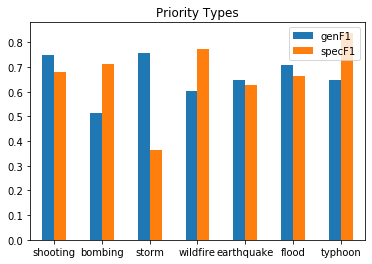

In [477]:
#priority
infile = open('prio_results','rb')
prioDF = pickle.load(infile)
infile.close()

#plt.figure(figsize=(7, 5))
ax = plt.axes()

genF1 = [item for item in prioDF['genF1']]
specF1 = [item for item in prioDF['specF1']]
index = [item for item in prioDF['Event']]

df_prio = pd.DataFrame({'genF1': genF1,

                   'specF1': specF1}, index=index)

ax.set_title('Priority Types')
ax = df_prio.plot.bar(rot=0, ax=ax)

plt.show()

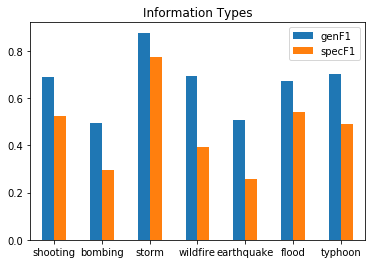

In [476]:
#categories
infile = open('cat_results','rb')
prioDF = pickle.load(infile)
infile.close()

ax = plt.axes()

catgenF1 = [item for item in catDF['genF1']]
catspecF1 = [item for item in catDF['specF1']]
index = [item for item in catDF['Event']]

df2 = pd.DataFrame({'genF1': catgenF1,

                   'specF1': catspecF1}, index=index)

ax.set_title('Information Types')

ax = df2.plot.bar(rot=0, ax=ax)
plt.show()

# Troubleshooting (DO NOT DELETE)

In [461]:
MultiLabelBinarizer().fit_transform(df['postCategories'])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1]])

In [443]:
def troubleshoot_cat(data, features, target, modelType):
    
    categories = category_list(df)
    add_row = data.append(pd.Series(name='delete')) #adds an empty row
    add_row[target] = add_row[target].astype('object') #enables lists to be added to cell
    add_row.at['delete', target] = categories #adds list of all categories to cell to pad
        
    y = MultiLabelBinarizer().fit_transform(add_row[target]) #this should yield 25 in second dimension
    print("shape:", y.shape)
    
    y_train = y[:-1, :]
    print("shape after drop:", y_train.shape)
    
    model = clone(modelType)
    model.fit(data[features], y_train)
    
    return model

def troubleshoot_events(data, features, target, modelType):
    modelList = {}
    for event in tqdm(eventTypes):
        print('event:', event)
        #Create training and test dataframe
        eventDF = df.loc[df['eventType']==event]
        
        training = train_data(eventDF, 'eventID', heldout_events[event])
        
        #generate event specific model
        model = troubleshoot_cat(training, features, target, modelType)
        
        #Add model to list
        modelList[event] = model
        
        #print('')
    return modelList

Troubleshoot_models = troubleshoot_events(df, features, catLabel, catModel)

  0%|          | 0/7 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


event: shooting
shape: (7600, 25)
shape after drop: (7599, 25)


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.0s finished
[Parallel(n

event: bombing
shape: (433, 25)
shape after drop: (432, 25)


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n

event: storm
shape: (610, 25)
shape after drop: (609, 25)


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


event: wildfire
shape: (3690, 25)
shape after drop: (3689, 25)


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.1s finished
[Parallel(n

event: earthquake
shape: (4114, 25)
shape after drop: (4113, 25)


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


event: flood
shape: (4247, 25)
shape after drop: (4246, 25)


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.2s finished
[Parallel(n

event: typhoon
shape: (7450, 25)
shape after drop: (7449, 25)


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


In [444]:
def troubleshoot(data, features, target, model):
    print('EVENT:', event)
    categories = category_list(df)
    add_row = data.append(pd.Series(name='delete')) #adds an empty row
    add_row[target] = add_row[target].astype('object') #enables lists to be added to cell
    add_row.at['delete', target] = categories #adds list of all categories to cell to pad
    
    y_test = MultiLabelBinarizer().fit_transform(add_row[target]) #this should yield 25 in second dimension
    print("shape:", y_test.shape)
    
    y_test = y_test[:-1, :]
    print("shape after drop:", y_test.shape)

    X_test = data[features]
    y_infer_local = model.predict(X_test)
    print("target shape:", y_infer_local.shape) #target shape has one less dimension than expected
    
    local_f1 = f1_score(y_test, y_infer_local, average="weighted")
    local_score = model.score(X_test, y_test)
    
    #print("\tAccuracy:", local_score)
    #print("\tF1:", local_f1)
    return [local_score, local_f1]

eventTypes = ['shooting', 'bombing', 'storm', 'wildfire', 'earthquake', 'flood', 'typhoon']

for event in eventTypes:
    specScores = troubleshoot(testDf, features, catLabel, Troubleshoot_models[event])

EVENT: shooting
shape: (533, 25)
shape after drop: (532, 25)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

target shape: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

EVENT: bombing
shape: (533, 25)
shape after drop: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

EVENT: storm
shape: (533, 25)
shape after drop: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

EVENT: wildfire
shape: (533, 25)
shape after drop: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

EVENT: earthquake
shape: (533, 25)
shape after drop: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

EVENT: flood
shape: (533, 25)
shape after drop: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

EVENT: typhoon
shape: (533, 25)
shape after drop: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

target shape: (532, 25)


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

In [418]:
#troubleshooting category dimensions

eventDf = df.loc[df['eventType']=='bombing']

def category_list(eventDf):
    #this should return a list
    categories = []
    for i in eventDf['postCategories']:
        for j in i:
            categories.append(j)
            
    categories = (set(categories))
    return list(categories)

categories = category_list(eventDf)
len(categories)

for event in eventTypes:
    eventDf = df.loc[df['eventType']== event]
    categories = category_list(eventDf)
    print('Event:', event, "; #cat:", len(categories))
    
'''bombing, flood missing an expected dimension in generation of model (scroll up) '''

'''however, that doesn't seem to affect the testing because flood is fine. only shooting, bombing, and storm
have issues, and they're the only ones with less than 25 categories'''

Event: shooting ; #cat: 23
Event: bombing ; #cat: 22
Event: storm ; #cat: 21
Event: wildfire ; #cat: 25
Event: earthquake ; #cat: 25
Event: flood ; #cat: 25
Event: typhoon ; #cat: 25


In [395]:
#troubleshooting

eventDf = df.loc[df['eventType']=='shooting']
testDf = test_data(eventDf, 'eventID', heldout_events['wildfire'])


x = [i for i in testDf['postCategories']]

#messing around

d = {'col1': [1, 2], 'col2': [3, 4]}

dd = pd.DataFrame(d)

new = dd.append(pd.Series(name='delete'))

new['col1'] = new['col1'].astype('object')

new.at['delete', 'col1'] = categories

new.drop(['delete'])

,col1,col2
0,1,3.0
1,2,4.0


In [555]:
d = {'col1': [1, 2], 'col2': [3, 4], 'col3': [5, 6]}
dd = pd.DataFrame(d)
dd

hello = dd.transpose().columns.to_list()
hello[-1]


#transposed = dd.transpose().pop(str(len(dd)-1))
#dd = transposed.transpose()

1

In [ ]:

length = len(dd)
length

hi = hello.pop((length-1))

hello.transpose()

# Info Types + Priority (heldout crisis)
For each crisis event, construct machine learning models for info-type and priority by training only on all other crisis events of the same type, and evaluate that model on the held-out crisis

In [570]:
'''

1. Iterate through event types

    a. Create an eventDF that has only crisis events of the same type, minus a heldout crisis
        i. save the held-out crisis for later evaluation (return statement)
            ***to make things simpler, for now I am using the last crisis in each dataframe as the heldout***
            
    b. Train model on EventDF
        i. use the SpecScores structure
            - you need to run this for both cat and prio
            
    c. Evaluate on heldout event for both cat and prio
        i. Save the result in DataFrame
        
   d. Visualize Dataframe


'''

# 1.a
def preprocess(data, event):
    eventDF_all = data.loc[data['eventType']==event]
    transposed = eventDF_all.transpose()
    col = transposed.columns.to_list()[-1]

    heldout_crisis = transposed.pop(col)
    eventDF = transposed.transpose()
    
    #print(len(eventDF_all),len(eventDF))
   # print('heldout_crisis:', heldout_crisis)
   # print('eventDF:', eventDF.head(2))
    
    return heldout_crisis, eventDF

### 1.b Generate and Train Priority and Category Models
From 1.a you should have a function to create evendDFs with one crisis left out. Train the event-specific model on these.

In [559]:
#Priority Model
prioLabel = 'postPriority'
prioModel = RandomForestClassifier(**rf_params) #(**modelParameters)

def generate_both_prio_model(data, features, target, modelType):
    modelList = {}
    for event in tqdm(eventTypes):
        print(event)
        #Create training and test dataframe
        heldout_crisis, eventDF = preprocess(data, event)
        
        training = train_data(eventDF, 'eventID', heldout_events[event])
        
        #generate event specific model
        model = generate_model(training, features, target, modelType)
        
        #Add model to list
        modelList[event] = model
        
        #print('')
    return modelList

#generate event specific models
bothPrioModels = generate_both_prio_model(df, features, prioLabel, prioModel)

  0%|          | 0/7 [00:00<?, ?it/s]

wildfire


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished
 14%|█▍        | 1/7 [00:01<00:07,  1.31s/it]

earthquake


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished
 29%|██▊       | 2/7 [00:02<00:06,  1.38s/it]

flood


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.1s finished
 43%|████▎     | 3/7 [00:04<00:05,  1.38s/it]

typhoon


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.1s finished
 57%|█████▋    | 4/7 [00:06<00:05,  1.75s/it]

shooting


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.9s finished
 71%|███████▏  | 5/7 [00:09<00:03,  1.96s/it][Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


bombing


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished
 86%|████████▌ | 6/7 [00:09<00:01,  1.46s/it][Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


storm


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.2s finished
100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


### 1.c Test

In [577]:
heldout_crisis, eventDF = preprocess(df, 'wildfire')
heldout_crisis.to_frame().transpose()

,eventID,eventType,postID,postCategories,postPriority,text,entities,extended_entities,favorite_count,hashtagEntities,...,bool_EmergingThreats,bool_Weather,bool_Volunteer,bool_Hashtags,bool_OriginalEvent,bool_ContextualInformation,bool_InformationWanted,bool_GoodsServices,bool_SearchAndRescue,bool_Location
33490,siberianWildfires2020,wildfire,1158427750069182464,[Irrelevant],Low,Dramatic moment Russian military base explodes...,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1158427744339759111, 'id_str...",2,None,...,False,False,False,False,False,False,False,False,False,False


0    siberianWildfires2020
Name: wildfire, dtype: object

In [589]:
#Priority Models

def test_data(data, column, heldout_ids):
    test = data.loc[data[column].isin(heldout_ids)]
    
    return test

def test_prio_model(data, features, target, model):
    X_test = data[features]
    y_test = data[target]
    y_infer_local = model.predict(X_test)
    local_f1 = f1_score(y_test, y_infer_local, average="weighted")
    local_score = model.score(X_test, y_test)
    
    #print("\tAccuracy:", local_score)
    #print("\tF1:", local_f1)
    return [local_score, local_f1]

bothPrioModels

prio_final_df = pd.DataFrame(columns=['Event', 'Accuracy', 'F1'])
for event in tqdm(eventTypes):
    print(event)
    heldout_crisis, eventDF = preprocess(df, event)
    testDf = heldout_crisis.to_frame().transpose()
    specScores = test_prio_model(testDf, features, prioLabel, bothPrioModels[event])
    prio_final_df = prio_final_df.append({'Event':event, 'Accuracy':specScores[0], 'F1':specScores[1]}, ignore_index=True)

prio_final_df

  0%|          | 0/7 [00:00<?, ?it/s]

wildfire


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
 14%|█▍        | 1/7 [00:00<00:01,  4.00it/s]

earthquake


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
 29%|██▊       | 2/7 [00:00<00:01,  2.95it/s]

flood


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
 43%|████▎     | 3/7 [00:01<00:01,  3.04it/s]

typhoon


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
 57%|█████▋    | 4/7 [00:01<00:01,  2.67it/s]

shooting


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
 71%|███████▏  | 5/7 [00:02<00:00,  2.49it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
 86%|████████▌ | 6/7 [00:02<00:00,  3.05it/s]

bombing
storm


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.0s finished
100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


In [590]:
# do NOT run this again if you did not rerun model testing

filename = 'both_prio'
outfile = open(filename,'wb')
pickle.dump(prio_final_df,outfile)
outfile.close()

### 1.d Visualization

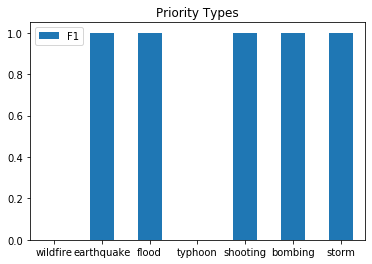

In [592]:
#priority
infile = open('both_prio','rb')
both_prio_df = pickle.load(infile)
infile.close()

#plt.figure(figsize=(7, 5))
ax = plt.axes()

F1 = [item for item in both_prio_df['F1']]
index = [item for item in both_prio_df['Event']]

both_priority = pd.DataFrame({'F1': F1}, index=index)

ax.set_title('Priority Types')
ax = both_priority.plot.bar(rot=0, ax=ax)

plt.show()

#### Playground

In [ ]:
## Going backwards ##


#Train Priority Model

#Test postPriority models
prio_final_df = pd.DataFrame(columns=['Event', 'Accuracy', 'F1'])
for event in eventTypes:
    eventDf = df.loc[df['eventType']==event]
    testDf = test_data(eventDf, 'eventID', heldout_events[event])
    specScores = test_prio_model(testDf, features, prioLabel, specPrioModels[event])
    prioDF = prioDF.append({'Event':event, 'Accuracy':genScores[0], 'F1':genScores}, ignore_index=True)

prio_final_df

#Test postCategories models
cat_final_df = pd.DataFrame(columns=['Event', 'Accuracy', 'F1'])
for event in eventTypes:
    eventDf = df.loc[df['eventType']==event]
    testDf = test_data(eventDf, 'eventID', heldout_events[event])
    genScores = test_cat_model(testDf, features, catLabel, genCatModel)
    specScores = test_cat_model(testDf, features, catLabel, specCatModels[event])
    catDF = catDF.append({'Event':event, 'genAccuracy':genScores[0], 'genF1':genScores[1],
               'specAccuracy':specScores[0], 'specF1':specScores[1]}, ignore_index=True)
cat_final_df